In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import pandas as pd
import glob
import sipm.util.functions as func
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
!pwd

/home/as111/sipm-analysis


In [3]:
# data folder
path = "/scratch/gpfs/as111/results/2022-11-22/"
data_spe = {}
positions = ['top', 'bottom']
channels = [0, 1, 2, 3]
voltages = [63, 65, 67, 69, 71]
for pos in positions:
    data_spe[pos] = {}
    for ch in channels:
        data_spe[pos][ch] = {}
        for volt in voltages:
            data_spe[pos][ch][volt] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
            files = glob.glob(f"{path}/*volt_{volt}_pos_{pos}*_laser_waveform.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data_spe[pos][ch][volt]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
                if data_spe[pos][ch][volt]['time'].shape[0]==0:
                    data_spe[pos][ch][volt]['time'] = np.array(df['time'])
                if data_spe[pos][ch][volt]['avg_spe_wf'].shape[0]==0:
                    data_spe[pos][ch][volt]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
                else:
                    data_spe[pos][ch][volt]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            df = None
            data_spe[pos][ch][volt]['avg_spe_wf'] /= data_spe[pos][ch][volt]['n_spe_wfs']
print('keys: ', list(data_spe['top'][0][63].keys()))

keys:  ['n_spe_wfs', 'avg_spe_wf', 'time']


top ch0 63V 63604 waveforms selected
top ch0 65V 57580 waveforms selected
top ch0 67V 51528 waveforms selected
top ch0 69V 47122 waveforms selected
top ch0 71V 42582 waveforms selected
top ch1 63V 44717 waveforms selected
top ch1 65V 38749 waveforms selected
top ch1 67V 33119 waveforms selected
top ch1 69V 29974 waveforms selected
top ch1 71V 25953 waveforms selected
top ch2 63V 48227 waveforms selected
top ch2 65V 41733 waveforms selected
top ch2 67V 36132 waveforms selected
top ch2 69V 32584 waveforms selected
top ch2 71V 28589 waveforms selected
top ch3 63V 63201 waveforms selected
top ch3 65V 57378 waveforms selected
top ch3 67V 51817 waveforms selected
top ch3 69V 46732 waveforms selected
top ch3 71V 42262 waveforms selected
bottom ch0 63V 51767 waveforms selected
bottom ch0 65V 45033 waveforms selected
bottom ch0 67V 39703 waveforms selected
bottom ch0 69V 35163 waveforms selected
bottom ch0 71V 31184 waveforms selected
bottom ch1 63V 54996 waveforms selected
bottom ch1 65V 48947

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

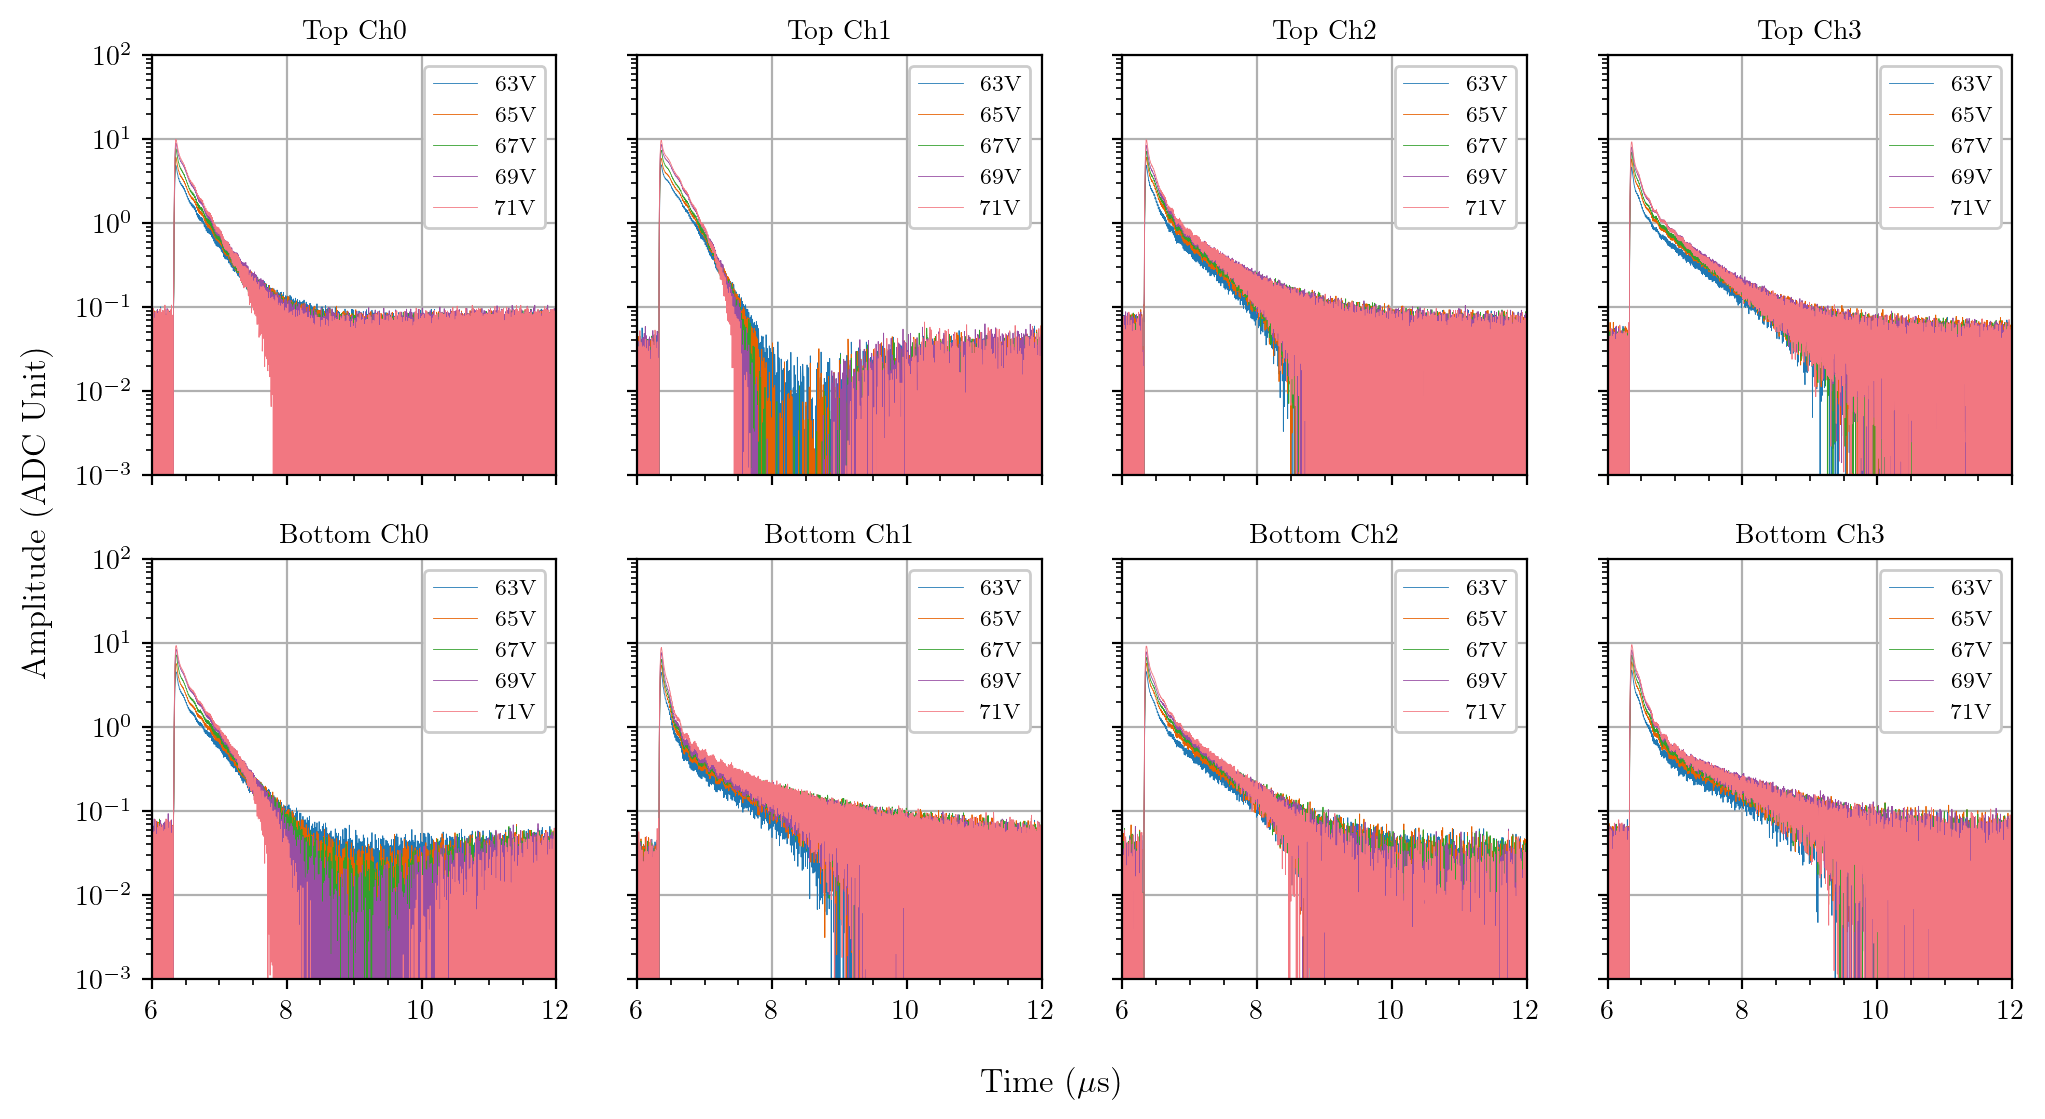

In [4]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            print(f'{pos} ch{ch} {volt}V {data_spe[pos][ch][volt]["n_spe_wfs"]:.0f} waveforms selected')
            axs[i, j].plot(
                data_spe[pos][ch][volt]['time'],
                data_spe[pos][ch][volt]['avg_spe_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## FFT

Text(0.07, 0.5, 'FFT Abs. Amplitude (ADC Unit)')

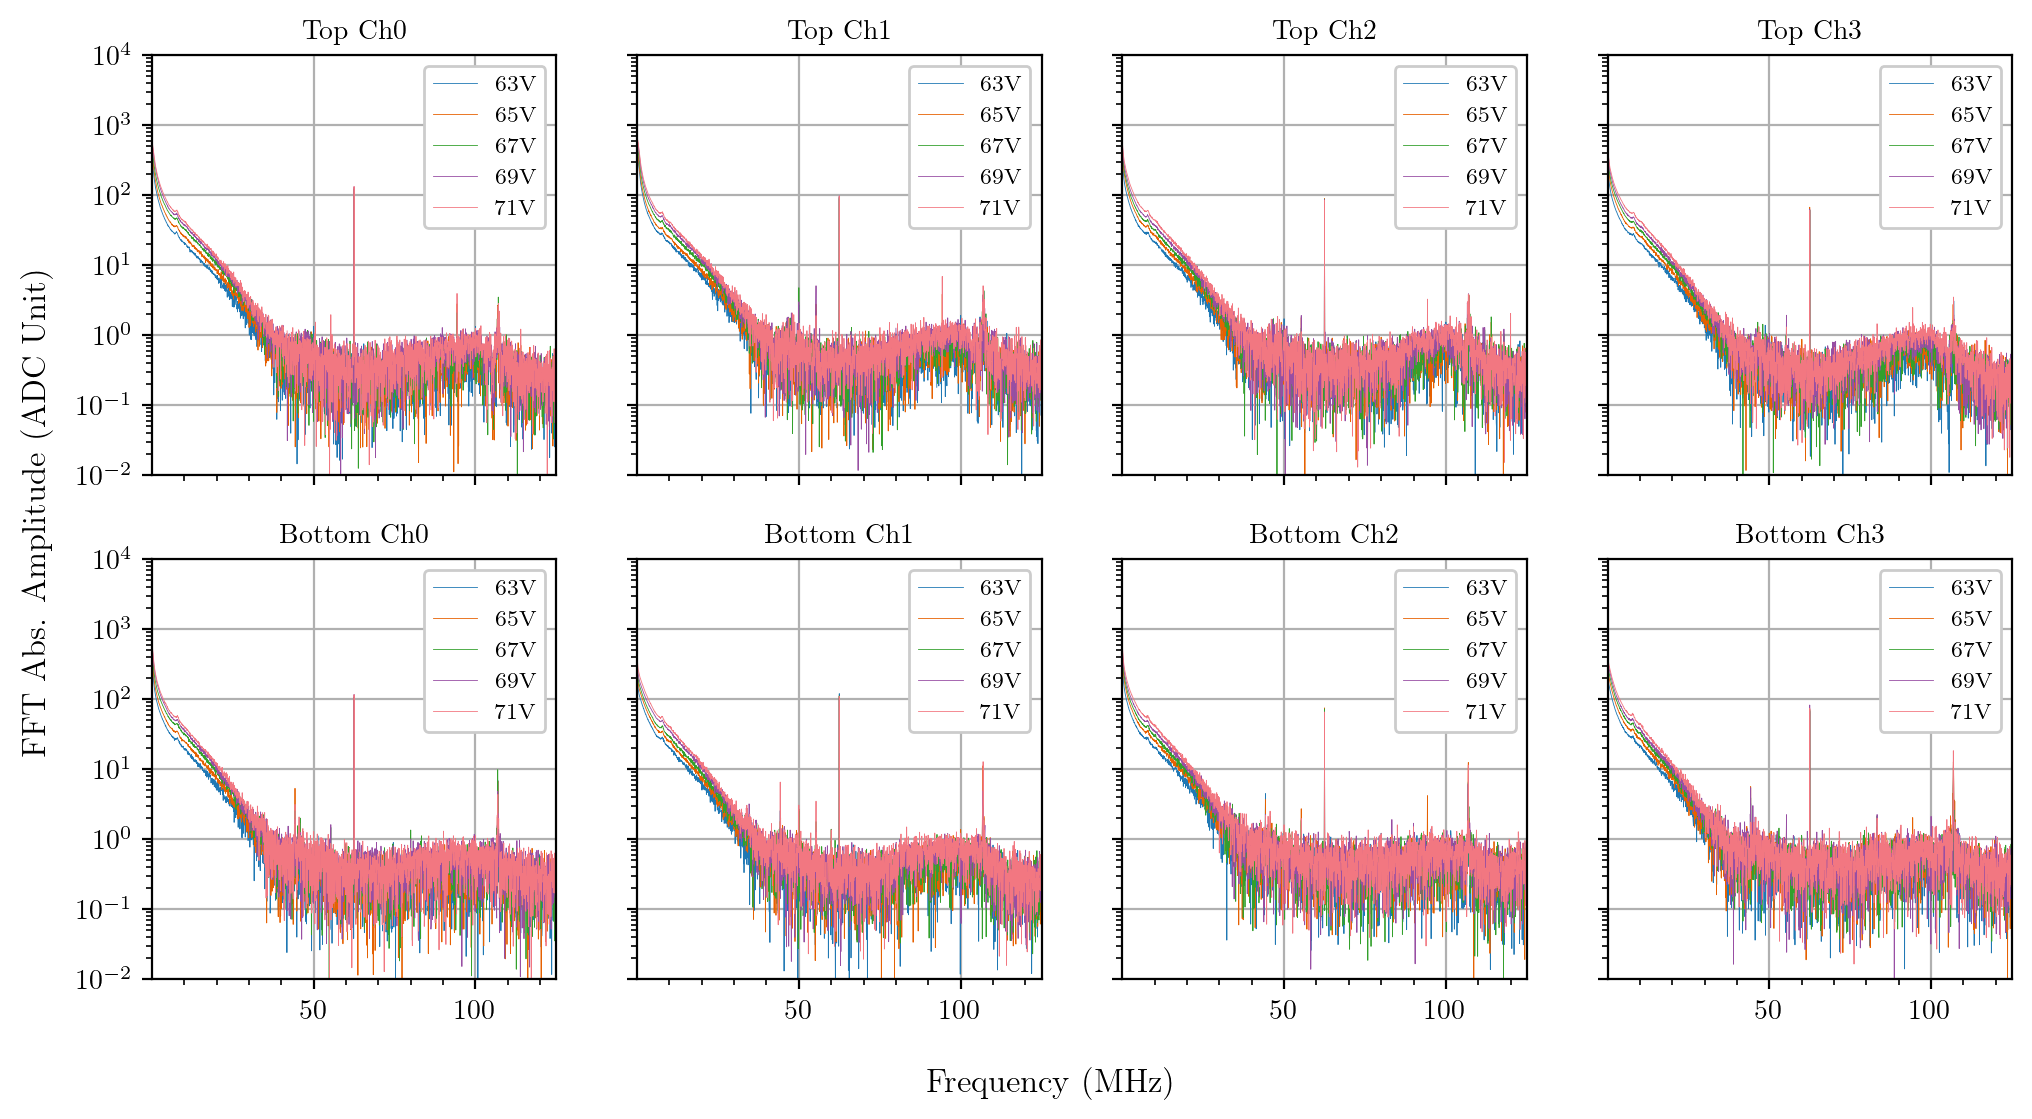

In [5]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            data_spe[pos][ch][volt]['fft_spe_wf'] = fft(data_spe[pos][ch][volt]['avg_spe_wf'])
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            t_total = dt+data_spe[pos][ch][volt]['time'][-1]
            n_over_2 = int(data_spe[pos][ch][volt]['time'].shape[0]/2)
            data_spe[pos][ch][volt]['frequency'] = data_spe[pos][ch][volt]['time']/dt/t_total
            axs[i, j].plot(
                data_spe[pos][ch][volt]['frequency'][:n_over_2],
                abs(data_spe[pos][ch][volt]['fft_spe_wf'][:n_over_2]),
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(data_spe[pos][ch][volt]['frequency'][1], data_spe[pos][ch][volt]['frequency'][n_over_2])
        # axs[i, j].set_xlim(0,5)
        axs[i, j].set_ylim(1e-2, 1e4)
        # axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'FFT Abs. Amplitude (ADC Unit)', x=0.07)

# Fit: exponential pulses with time jitter
Scintillation pulse (one component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$
We include two scintillation pulse components with distinct $\tau$.

In [6]:
def template(t, a_1, tau_1, a_2, tau_2, sigma, t0):
        return func.pulse_jitter(t, a_1, tau_1, sigma, t0) + func.pulse_jitter(t, a_2, tau_2, sigma, t0)

In [7]:
# Fit SPE average waveform
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            pretrg = 5 #us
            err = np.std(data_spe[pos][ch][volt]['avg_spe_wf'][data_spe[pos][ch][volt]['time']<pretrg])
            fit_range = [6.2,10] #us
            range_arr = (data_spe[pos][ch][volt]['time']<fit_range[1])&(data_spe[pos][ch][volt]['time']>fit_range[0])
            popt,pcov = curve_fit(
                template,
                data_spe[pos][ch][volt]['time'][range_arr], 
                data_spe[pos][ch][volt]['avg_spe_wf'][range_arr], 
                p0=[7, 0.05, 6, 0.7, 0.008, 6.34], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
            data_spe[pos][ch][volt]['pars'] = popt
            data_spe[pos][ch][volt]['cov'] = pcov

/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:504: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: invalid value encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

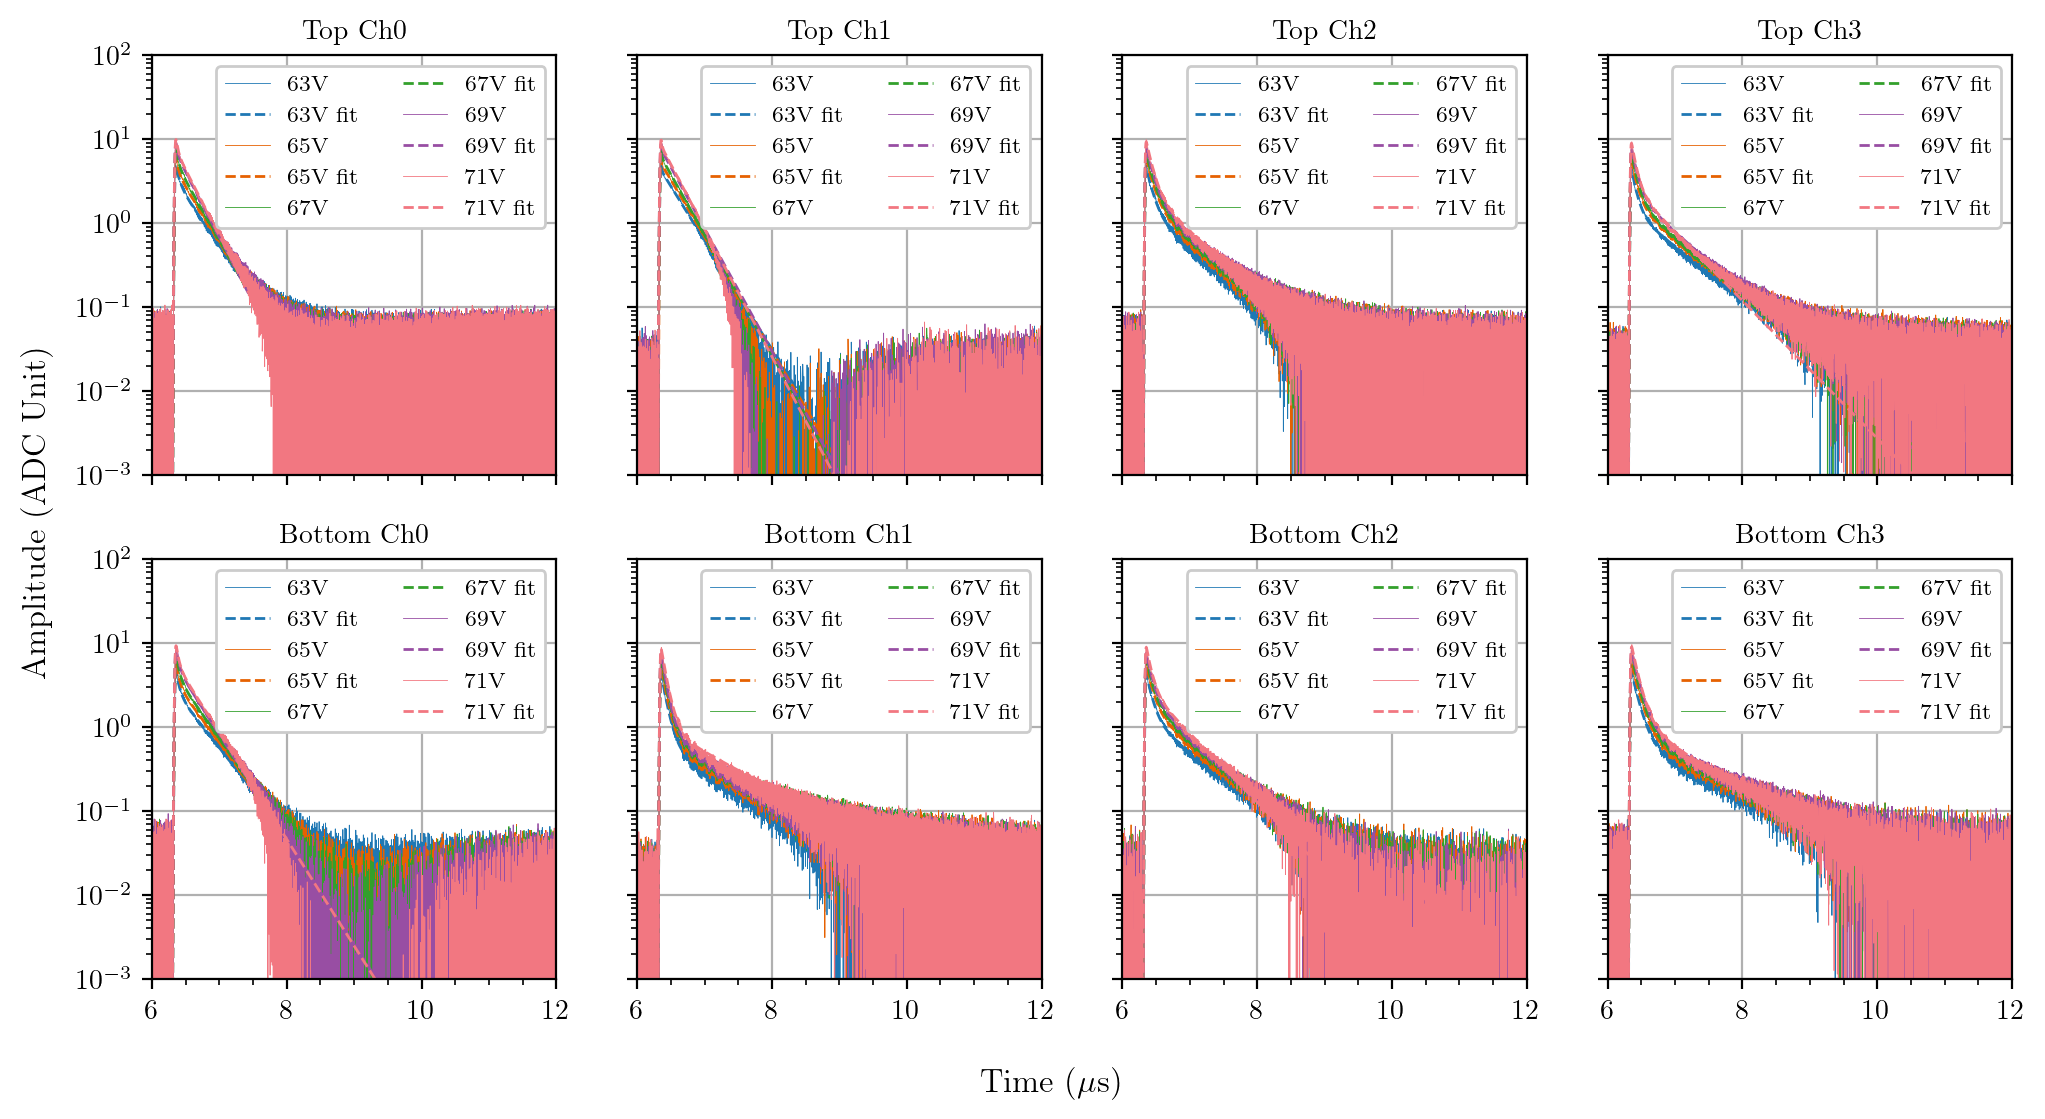

In [8]:
# Make plots for all datasets
# Fitted SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].plot(
                data_spe[pos][ch][volt]['time'],
                data_spe[pos][ch][volt]['avg_spe_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
            axs[i, j].plot(
                data_spe[pos][ch][volt]['time'],
                template(data_spe[pos][ch][volt]['time'], *data_spe[pos][ch][volt]['pars']),
                label=f'{volt}V fit', color=f'C{k}', linestyle='--', linewidth=1)
        axs[i, j].legend(loc='upper right',ncol=2)
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [9]:
# Fit result container
# Initialize
spe_fit = {}
for pos in positions:
    spe_fit[pos] = {}
    for ch in channels:
        spe_fit[pos][ch] = {}

In [10]:
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
            spe_fit[pos][ch]['volts'] = np.array(voltages)
            spe_fit[pos][ch]['a1'] = np.array([data_spe[pos][ch][volt]['pars'][0] for volt in voltages])
            spe_fit[pos][ch]['tau1'] = np.array([data_spe[pos][ch][volt]['pars'][1] for volt in voltages])
            spe_fit[pos][ch]['a2'] = np.array([data_spe[pos][ch][volt]['pars'][2] for volt in voltages])
            spe_fit[pos][ch]['tau2'] = np.array([data_spe[pos][ch][volt]['pars'][3] for volt in voltages])
            spe_fit[pos][ch]['a1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][0, 0]) for volt in voltages])
            spe_fit[pos][ch]['tau1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][1, 1]) for volt in voltages])
            spe_fit[pos][ch]['a2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][2, 2]) for volt in voltages])
            spe_fit[pos][ch]['tau2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][3, 3]) for volt in voltages])

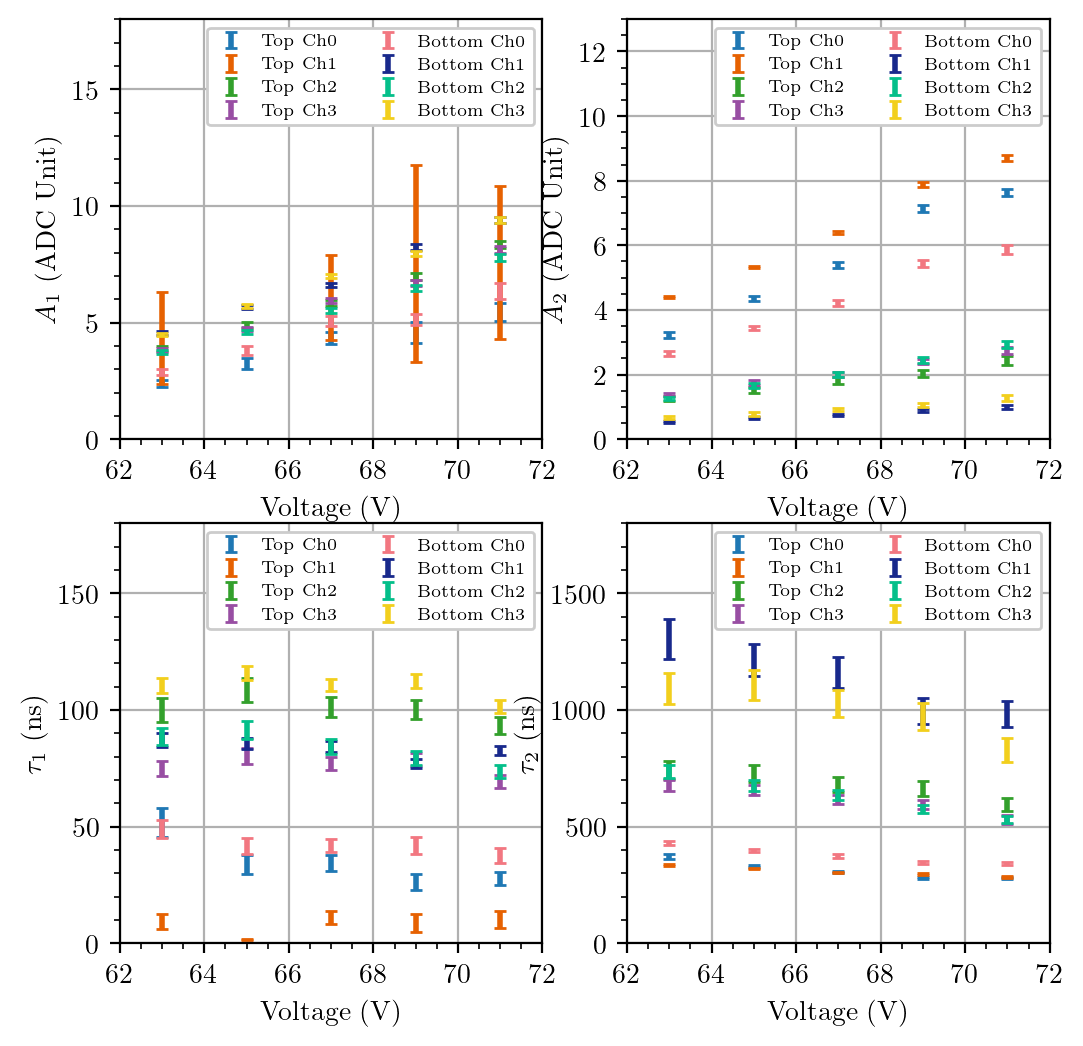

In [11]:
# Make plots for all parameters
# SPE average waveform
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_size_inches(6, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        axs[0, 0].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['a1'],
            yerr=spe_fit[pos][ch]['a1err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[0, 0].set_ylabel(r'$A_1$ (ADC Unit)')
        axs[0, 0].set_ylim(0,18)
        axs[0, 1].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['a2'],
            yerr=spe_fit[pos][ch]['a2err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[0, 1].set_ylabel(r'$A_2$ (ADC Unit)')
        axs[0, 1].set_ylim(0,13)
        axs[1, 0].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['tau1']*1e3,
            yerr=spe_fit[pos][ch]['tau1err']*1e3,
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[1, 0].set_ylabel(r'$\tau_1$ (ns)')
        axs[1, 0].set_ylim(0,180)
        axs[1, 1].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['tau2']*1e3,
            yerr=spe_fit[pos][ch]['tau2err']*1e3,
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[1, 1].set_ylabel(r'$\tau_2$ (ns)')
        axs[1, 1].set_ylim(0,1800)

for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel('Voltage (V)')
        axs[i, j].legend(loc='upper right',ncol=2,fontsize=6)
        axs[i, j].minorticks_on()
        axs[i, j].grid()

# 11/20 Triplet lifetime
Here the average waveforms are deconvolved channel-by-channel using their respective SPE pulse shapes.
The deconvolved waveform is given by
$$f_{deconv}(t) = \mathcal{F}^{-1}\left(\frac{\mathcal{F}(f_{original}(t))}{\mathcal{F}(f_{SiPM}(t))}\right)$$
Note that the SiPM pulse shape has to be shifted such that the trigger for it is at $t=0$.<br>

The average waveforms are selected from the events with $0.1<F_{\rm prompt}<0.5$ and $20<N_{\rm PE}<200$ ($100<N_{\rm PE}<1000$) for the top (bottom), corresponding to an energy range of $100$ keV $\lesssim E \lesssim 1000$ keV

In [12]:
# data folder
path_scint = "/scratch/gpfs/as111/results/2022-11-20/"
data_scint = {}
positions = ['top', 'bottom']
channels = [0, 1, 2, 3]
voltages = [63, 65, 67, 69, 71]
for pos in positions:
    data_scint[pos] = {}
    for ch in channels:
        data_scint[pos][ch] = {}
        for volt in voltages:
            data_scint[pos][ch][volt] = {'n_scint_wfs':0, 'avg_scint_wf':np.zeros(0), 'time':np.zeros(0)}
            files = glob.glob(f"{path_scint}/*volt_{volt}_pos_{pos}*scintillation_waveform.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data_scint[pos][ch][volt]['n_scint_wfs'] += np.array(df['n_scint_wfs'])[0]
                if data_scint[pos][ch][volt]['time'].shape[0]==0:
                    data_scint[pos][ch][volt]['time'] = np.array(df['time'])
                if data_scint[pos][ch][volt]['avg_scint_wf'].shape[0]==0:
                    data_scint[pos][ch][volt]['avg_scint_wf'] = np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
                else:
                    data_scint[pos][ch][volt]['avg_scint_wf'] += np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
            df = None
            data_scint[pos][ch][volt]['avg_scint_wf'] /= data_scint[pos][ch][volt]['n_scint_wfs']
print('keys: ', list(data_scint['top'][0][63].keys()))

keys:  ['n_scint_wfs', 'avg_scint_wf', 'time']


top ch0 63V 235433 waveforms selected
top ch0 65V 223150 waveforms selected
top ch0 67V 175010 waveforms selected
top ch0 69V 152415 waveforms selected
top ch0 71V 144322 waveforms selected
top ch1 63V 235433 waveforms selected
top ch1 65V 223150 waveforms selected
top ch1 67V 175010 waveforms selected
top ch1 69V 152415 waveforms selected
top ch1 71V 144322 waveforms selected
top ch2 63V 235433 waveforms selected
top ch2 65V 223150 waveforms selected
top ch2 67V 175010 waveforms selected
top ch2 69V 152415 waveforms selected
top ch2 71V 144322 waveforms selected
top ch3 63V 235433 waveforms selected
top ch3 65V 223150 waveforms selected
top ch3 67V 175010 waveforms selected
top ch3 69V 152415 waveforms selected
top ch3 71V 144322 waveforms selected
bottom ch0 63V 215869 waveforms selected
bottom ch0 65V 139791 waveforms selected
bottom ch0 67V 81002 waveforms selected
bottom ch0 69V 55261 waveforms selected
bottom ch0 71V 47957 waveforms selected
bottom ch1 63V 215869 waveforms select

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

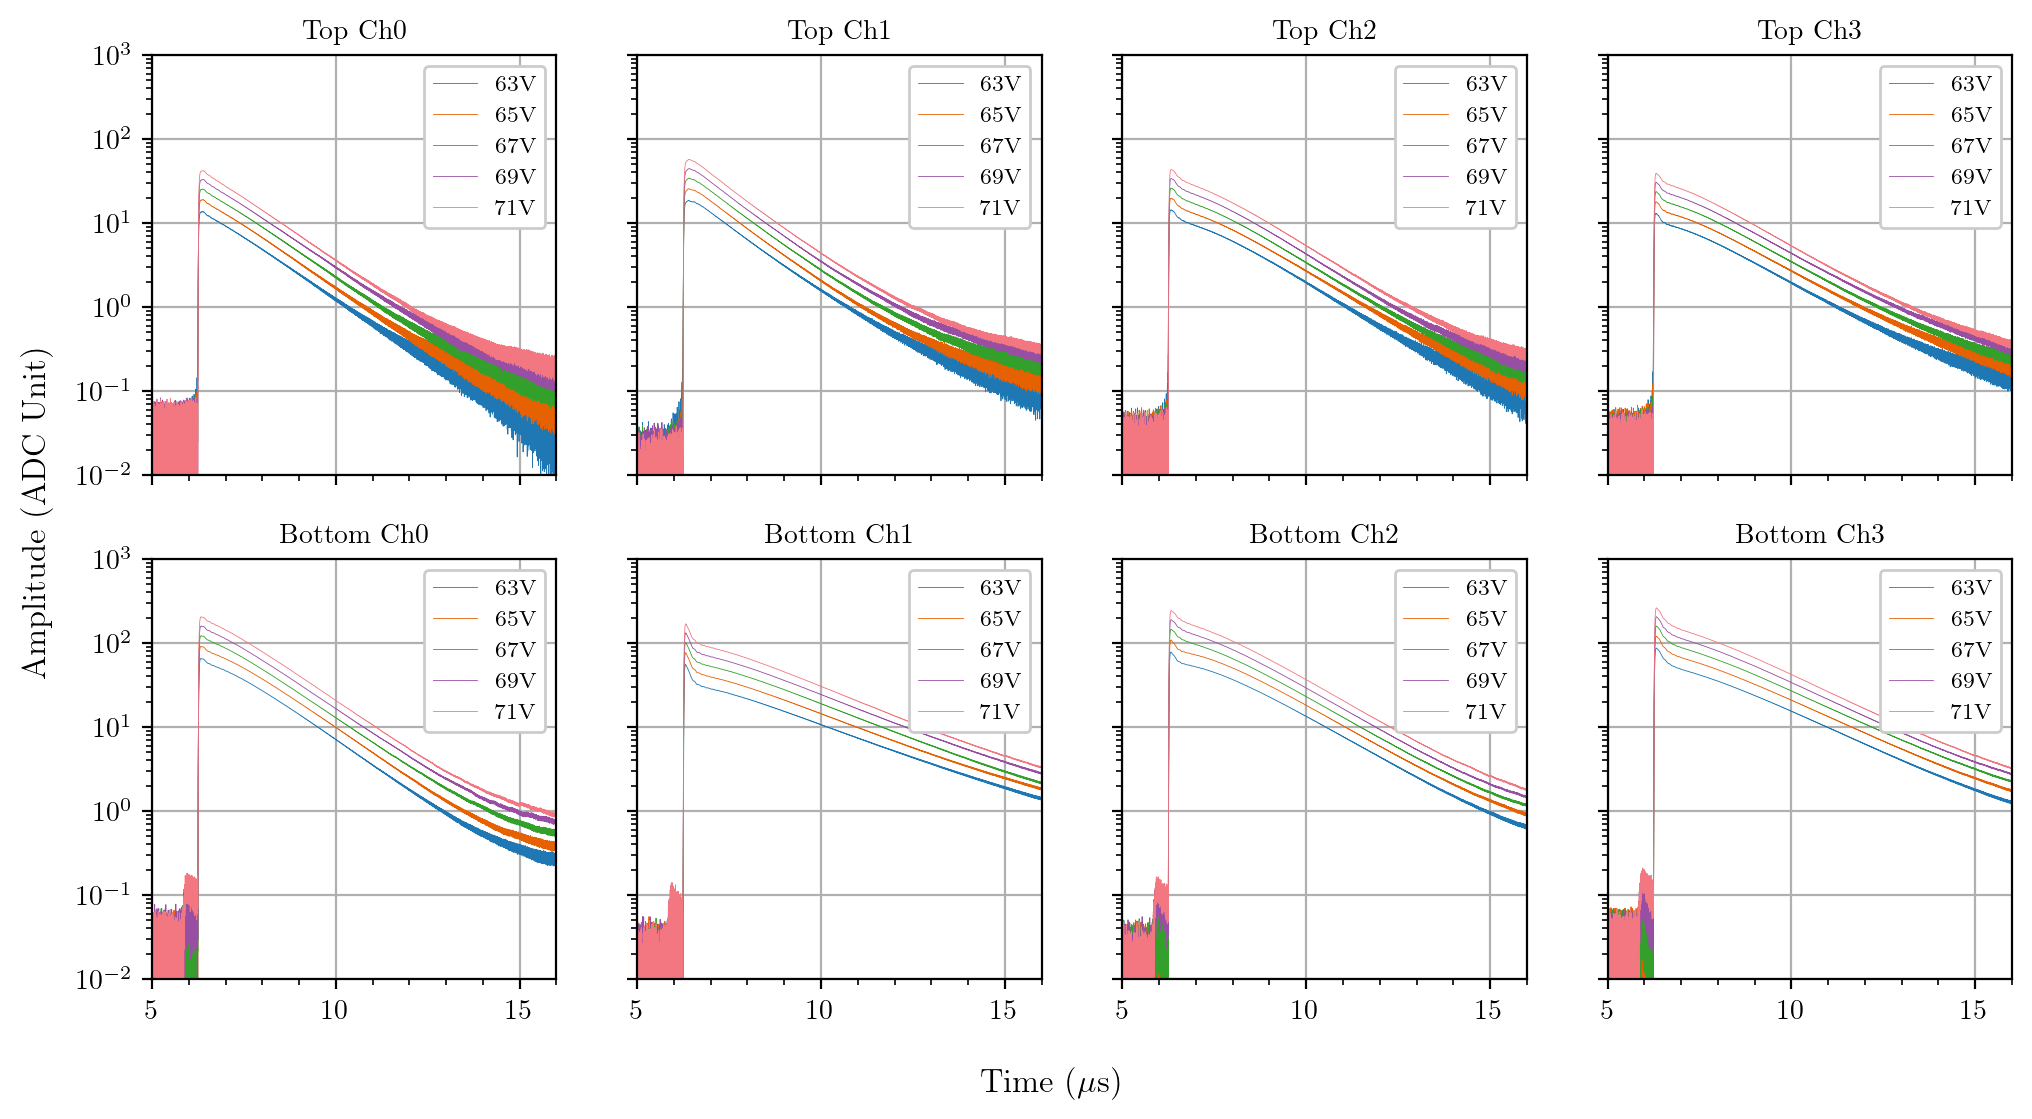

In [13]:
# Make plots for all datasets
# Average LAr scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            print(f'{pos} ch{ch} {volt}V {data_scint[pos][ch][volt]["n_scint_wfs"]:.0f} waveforms selected')
            axs[i, j].plot(
                data_scint[pos][ch][volt]['time'],
                data_scint[pos][ch][volt]['avg_scint_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(5, 16)
        axs[i, j].set_ylim(1e-2, 1e3)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Deconvolution

In [14]:
# Deconvolution channel by channel
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(data_spe[pos][ch][volt]['pars'][5]/dt))) for freq in data_spe[pos][ch][volt]['frequency']])
            data_scint[pos][ch][volt]['deconv'] = ifft(fft(data_scint[pos][ch][volt]['avg_scint_wf'])/data_spe[pos][ch][volt]['fft_spe_wf']*shift).real

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

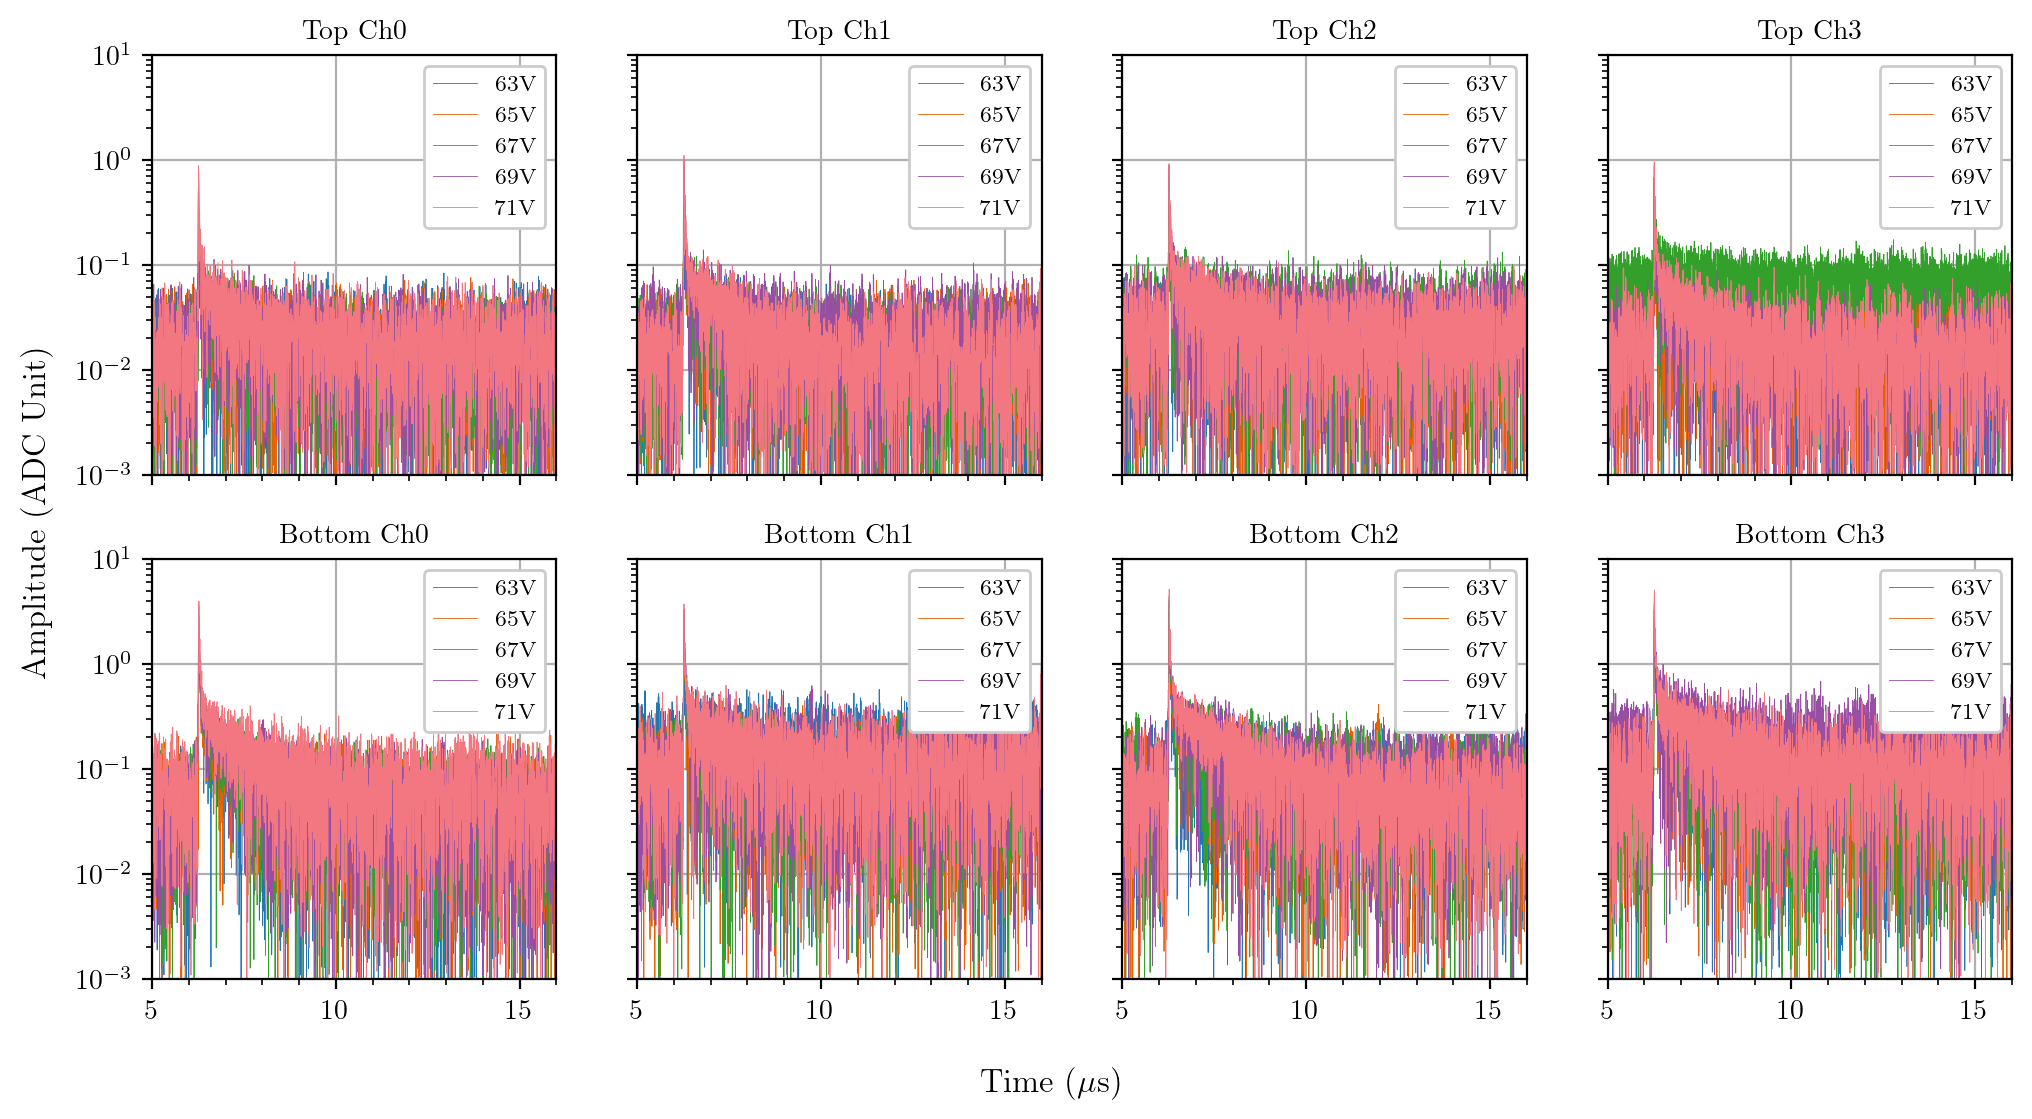

In [15]:
# Make plots for all datasets
# Deconvolved scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].plot(
                data_scint[pos][ch][volt]['time'],
                abs(data_scint[pos][ch][volt]['deconv']),
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(5, 16)
        axs[i, j].set_ylim(1e-3, 1e1)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Summation

In [16]:
for pos in positions:
    data_scint[pos][-1] = {}
    for volt in voltages:
        data_scint[pos][-1][volt] = {'time': data_scint[pos][0][volt]['time'], 'sum_wf': np.zeros(data_scint[pos][0][volt]['time'].shape[0])}
        for ch in channels:
            data_scint[pos][-1][volt]['sum_wf'] += data_scint[pos][ch][volt]['deconv']

Text(0.02, 0.5, 'Amplitude (ADC Unit)')

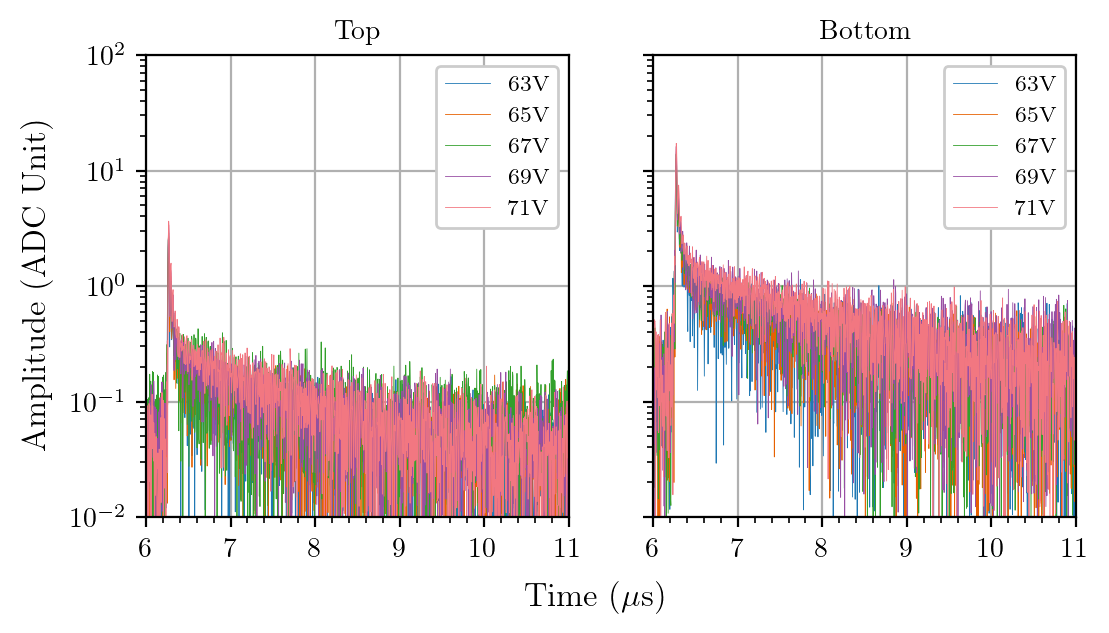

In [17]:
# Make plots for all datasets
# Summed scintillation waveform
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(6, 3)
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        axs[i].plot(
                    data_scint[pos][-1][volt]['time'],
                    abs(data_scint[pos][-1][volt]['sum_wf']),
                    label=f'{volt}V', color=f'C{j}', linewidth=0.3)
        axs[i].legend(loc='upper right')
        axs[i].set_xlim(6, 11)
        axs[i].set_ylim(1e-2, 1e2)
        axs[i].set_yscale('log')
        axs[i].minorticks_on()
        axs[i].grid()
        axs[i].set_title(f'{pos[0].upper()}{pos[1:]}')
fig.supxlabel(r'Time ($\mu$s)', y=-0.05)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.02)

## Fitting

In [18]:
# Fit SPE average waveform
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        pretrg = 5 #us
        err = np.std(data_scint[pos][-1][volt]['sum_wf'][data_scint[pos][-1][volt]['time']<pretrg])
        fit_range = [6.25,12] #us
        range_arr = (data_scint[pos][-1][volt]['time']<fit_range[1])&(data_scint[pos][-1][volt]['time']>fit_range[0])
        popt,pcov = curve_fit(
            template,
            data_scint[pos][-1][volt]['time'][range_arr], 
            data_scint[pos][-1][volt]['sum_wf'][range_arr], 
            p0=[10, 0.018, 0.7, 1.5, 0.003, 6.26], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
        data_scint[pos][-1][volt]['pars'] = popt
        data_scint[pos][-1][volt]['cov'] = pcov

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

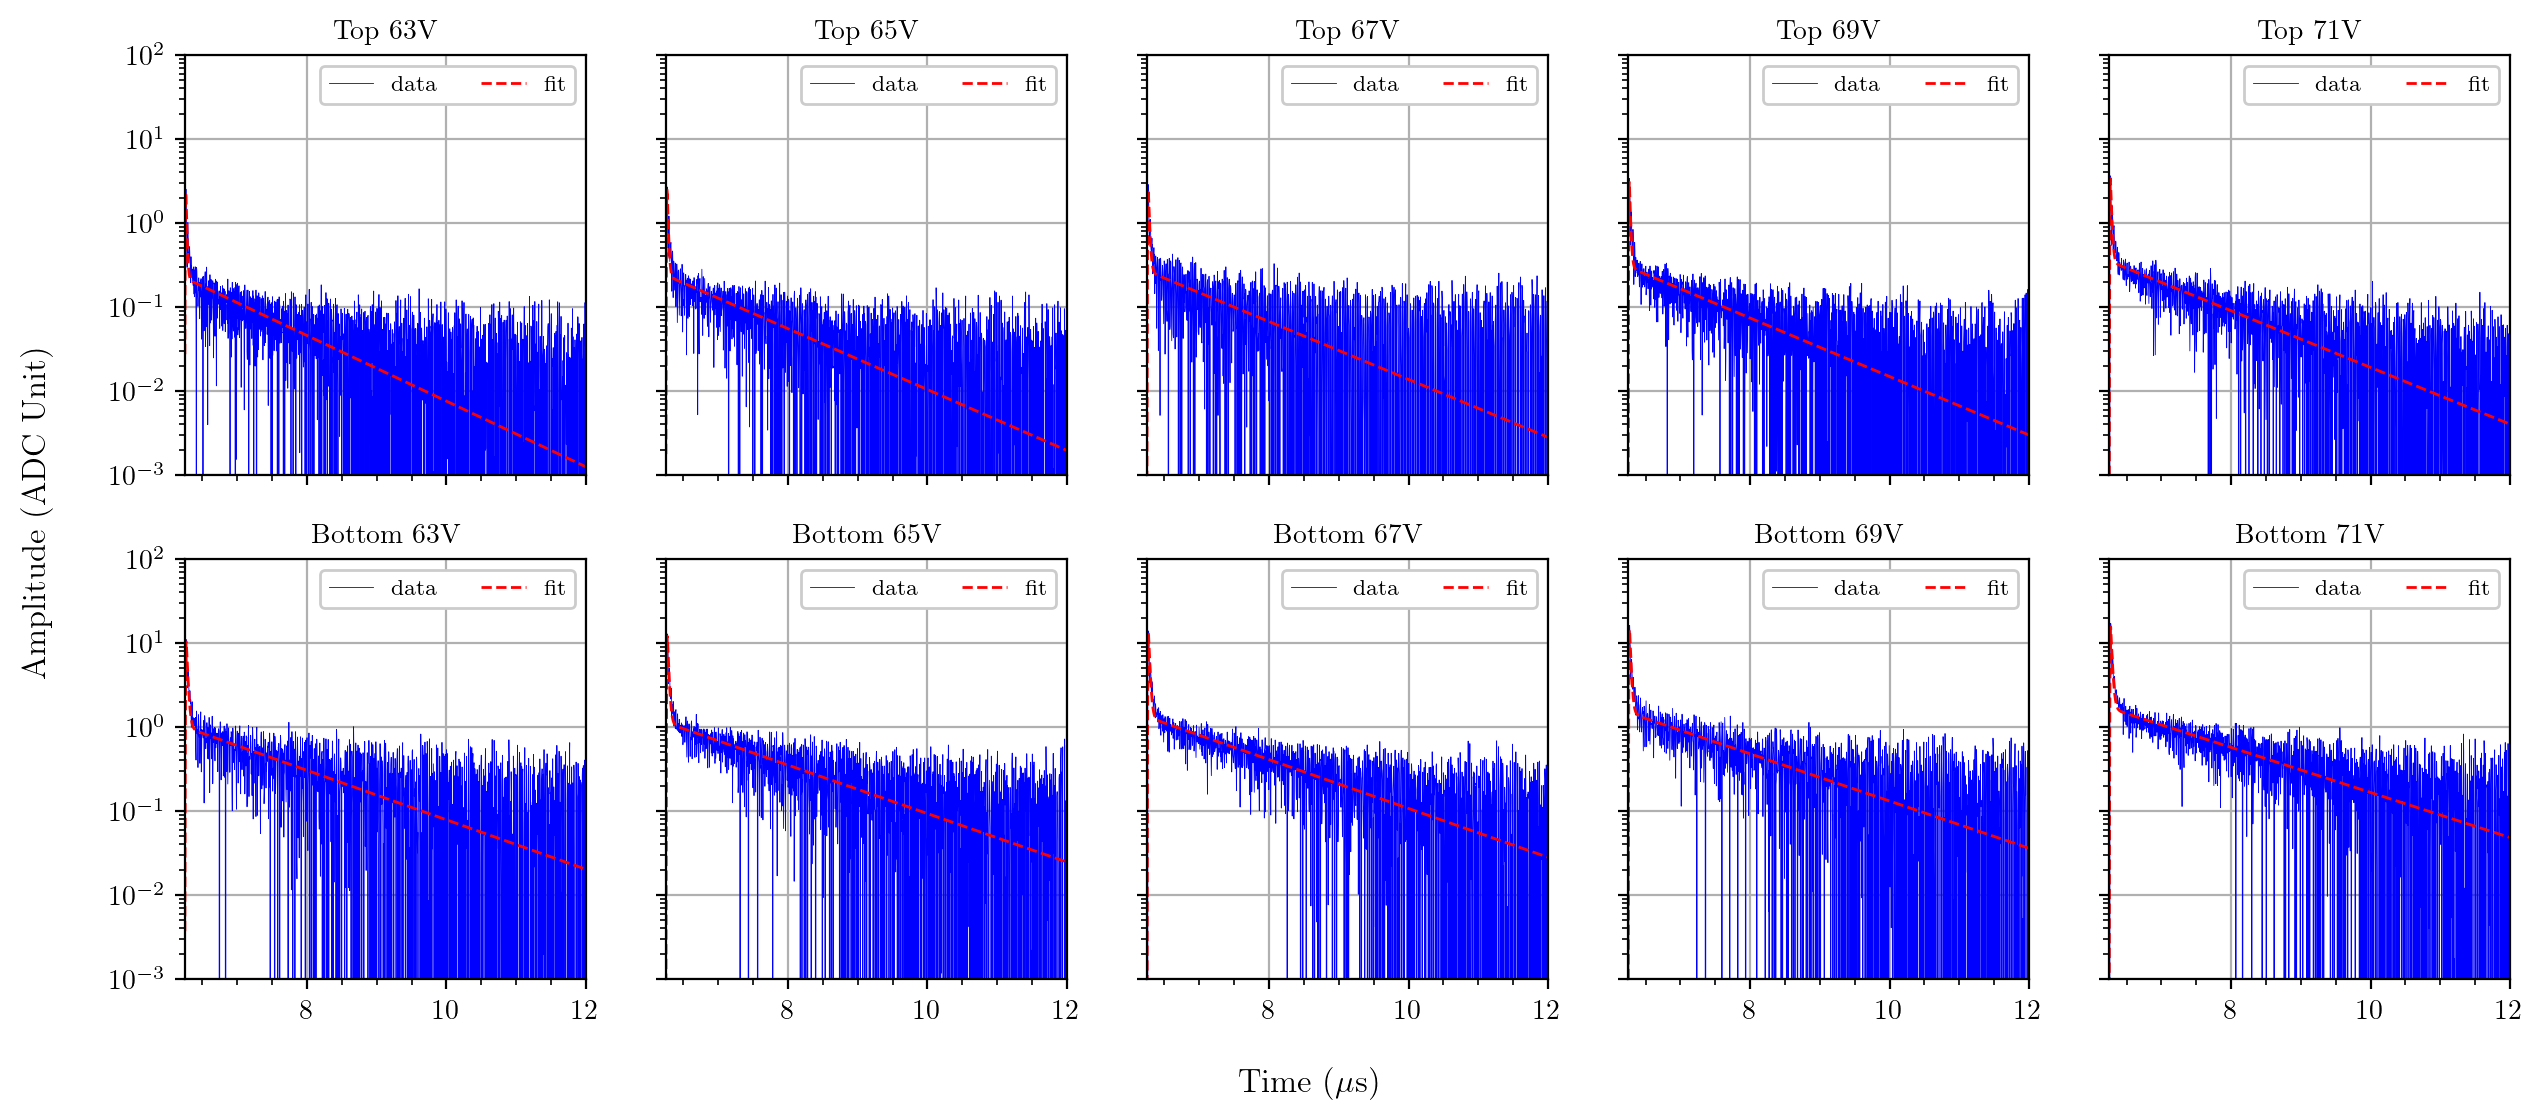

In [19]:
# Make plots for all datasets
# Fitted SPE average waveform
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
fig.set_size_inches(15, 6)
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        axs[i, j].plot(
            data_scint[pos][-1][volt]['time'],
            data_scint[pos][-1][volt]['sum_wf'],
            label=f'data', color='b', linewidth=0.3)
        axs[i, j].plot(
            data_scint[pos][-1][volt]['time'],
            template(data_scint[pos][-1][volt]['time'], *data_scint[pos][-1][volt]['pars']),
            label=f'fit', color='r', linestyle='--', linewidth=1)
        axs[i, j].legend(loc='upper right',ncol=2)
        axs[i, j].set_xlim(6.25, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} {volt}V')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [20]:
# Fit result container
# Initialize
scint_fit = {}
for pos in positions:
    scint_fit[pos] = {}

In [21]:
for pos in positions:
    scint_fit[pos]['volts'] = np.array(voltages)
    scint_fit[pos]['a1'] = np.array([data_scint[pos][-1][volt]['pars'][0] for volt in voltages])
    scint_fit[pos]['tau1'] = np.array([data_scint[pos][-1][volt]['pars'][1] for volt in voltages])
    scint_fit[pos]['a2'] = np.array([data_scint[pos][-1][volt]['pars'][2] for volt in voltages])
    scint_fit[pos]['tau2'] = np.array([data_scint[pos][-1][volt]['pars'][3] for volt in voltages])
    scint_fit[pos]['a1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_scint[pos][-1][volt]['cov'][0, 0]) for volt in voltages])
    scint_fit[pos]['tau1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_scint[pos][-1][volt]['cov'][1, 1]) for volt in voltages])
    scint_fit[pos]['a2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_scint[pos][-1][volt]['cov'][2, 2]) for volt in voltages])
    scint_fit[pos]['tau2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_scint[pos][-1][volt]['cov'][3, 3]) for volt in voltages])

Text(0.5, 0.01, 'Voltage (V)')

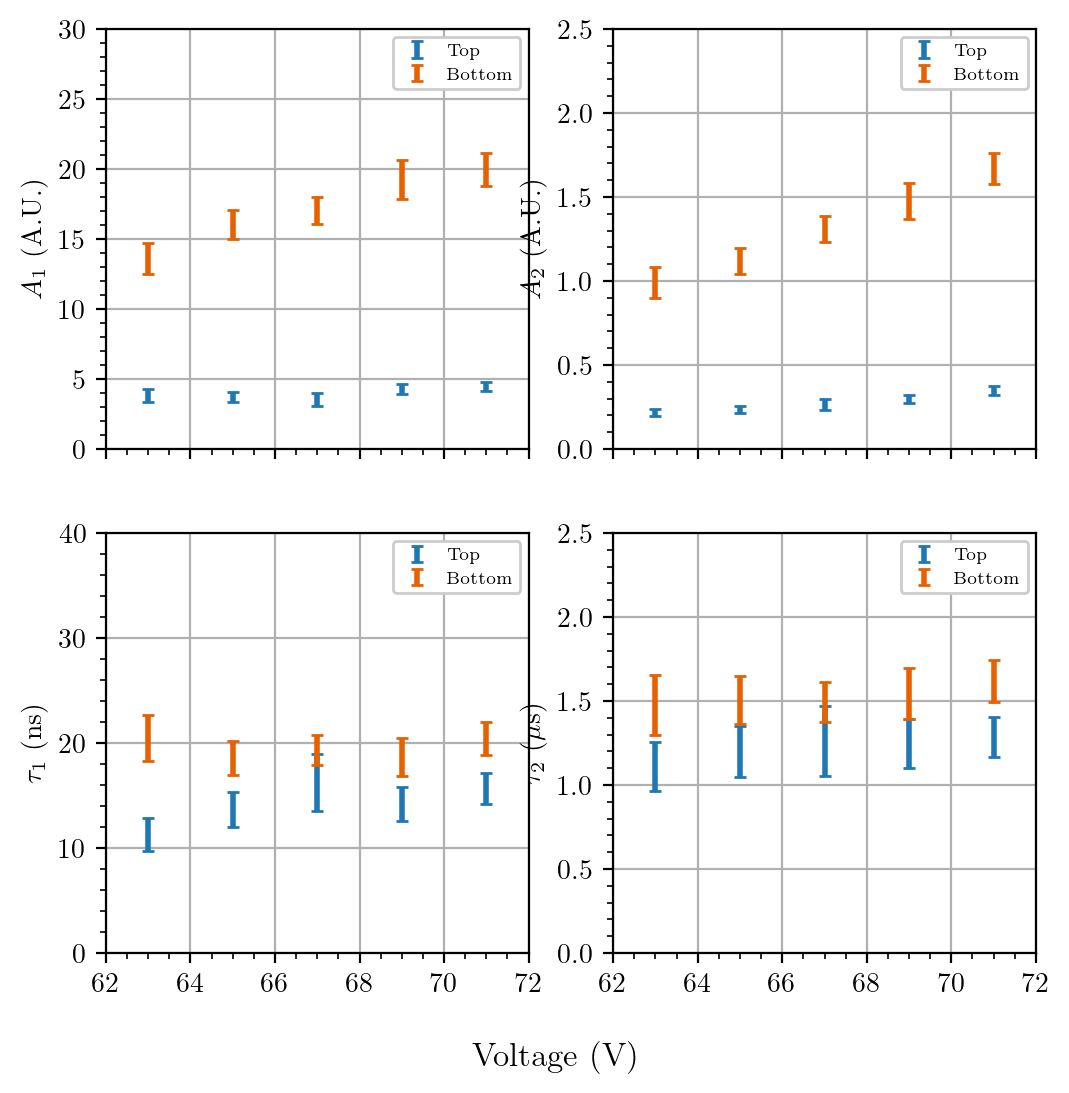

In [22]:
# Make plots for all parameters
# Scintillation waveform fit
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False)
fig.set_size_inches(6, 6)
for i, pos in enumerate(positions):
    axs[0, 0].errorbar(
        scint_fit[pos]['volts'],
        scint_fit[pos]['a1'],
        yerr=scint_fit[pos]['a1err'],
        label=f'{pos[0].upper()}{pos[1:]}', color=f'C{i}', linestyle='')
    axs[0, 0].set_ylabel(r'$A_1$ (A.U.)')
    axs[0, 0].set_ylim(0,30)
    axs[0, 1].errorbar(
        scint_fit[pos]['volts'],
        scint_fit[pos]['a2'],
        yerr=scint_fit[pos]['a2err'],
        label=f'{pos[0].upper()}{pos[1:]}', color=f'C{i}', linestyle='')
    axs[0, 1].set_ylabel(r'$A_2$ (A.U.)')
    axs[0, 1].set_ylim(0,2.5)
    axs[1, 0].errorbar(
        scint_fit[pos]['volts'],
        scint_fit[pos]['tau1']*1e3,
        yerr=scint_fit[pos]['tau1err']*1e3,
        label=f'{pos[0].upper()}{pos[1:]}', color=f'C{i}', linestyle='')
    axs[1, 0].set_ylabel(r'$\tau_1$ (ns)')
    axs[1, 0].set_ylim(0,40)
    axs[1, 1].errorbar(
        scint_fit[pos]['volts'],
        scint_fit[pos]['tau2'],
        yerr=scint_fit[pos]['tau2err'],
        label=f'{pos[0].upper()}{pos[1:]}', color=f'C{i}', linestyle='')
    axs[1, 1].set_ylabel(r'$\tau_2$ ($\mu$s)')
    axs[1, 1].set_ylim(0,2.5)

for i in range(2):
    for j in range(2):
        axs[i, j].legend(loc='upper right',fontsize=6)
        axs[i, j].minorticks_on()
        axs[i, j].grid()
fig.supxlabel('Voltage (V)')

# Triplet lifetime evolution

Get folder paths and days since the getter was turned on

In [23]:
data_dir = '/scratch/gpfs/as111/results/'

file_top = [] #[list of date file paths, days since getter on]
for i in range(16):
    file_top.append([glob.glob(f'{data_dir}2022-11-08/*run{i}_scintillation_waveform.h5'),2.0+(5.0+i*1.05)/24.0]) #1h 3min apart
file_top.append([glob.glob(f'{data_dir}2022-11-09/*pos_top*scintillation_waveform.h5'),2.0+4.5/24.0])
file_top.append([glob.glob(f'{data_dir}2022-11-10/*pos_top*cond_with_gamma_high_stat*scintillation_waveform.h5'),3.0+3.5/24.0])
file_top.append([glob.glob(f'{data_dir}2022-11-14/*pos_top*scintillation_waveform.h5'),7.0+0.5/24.0])
file_top.append([glob.glob(f'{data_dir}2022-11-15/*pos_top*scintillation_waveform.h5'),8.0+0.5/24.0])
file_top.append([glob.glob(f'{data_dir}2022-11-17/*pos_top*scintillation_waveform.h5'),10.0+0.5/24.0])
file_top.append([glob.glob(f'{data_dir}2022-11-18/*volt_65_pos_top*cond_gamma*scintillation_waveform.h5'),11.0+4.5/24.0])
file_top.append([glob.glob(f'{data_dir}2022-11-20/*volt_65_pos_top*cond_gamma*scintillation_waveform.h5'),13.0+4.5/24.0])

file_bot = []
for i in range(1,7):
    file_bot.append([glob.glob(f'{data_dir}2022-11-07/*purification_{i}*scintillation_waveform.h5'),i*45.0/60.0/24.0])
for i in range(12):
    file_bot.append([glob.glob(f'{data_dir}2022-11-07/*purification_overnight_run{i}_scintillation_waveform.h5'),(5.0+i*1.05)/24.0])
file_bot.append([glob.glob(f'{data_dir}2022-11-09/*pos_bottom*scintillation_waveform.h5'),2.0-0.5/24.0])
file_bot.append([glob.glob(f'{data_dir}2022-11-10/*pos_bottom*cond_gamma_high_stat*scintillation_waveform.h5'),3.0+5.0/24.0])
for i in range(20):
    file_bot.append([glob.glob(f'{data_dir}2022-11-10/*pos_bottom*cond_with_gamma_overnight_run{i}_scintillation_waveform.h5'),3.0+(5.5+i*4.0)/24.0])
file_bot.append([glob.glob(f'{data_dir}2022-11-15/*pos_bottom*cond_gamma_high_stat*scintillation_waveform.h5'),8.0+6.0/24.0])
for i in range(6):
    file_bot.append([glob.glob(f'{data_dir}2022-11-15/*pos_bottom*cond_gamma_overnight_run{i}_scintillation_waveform.h5'),8.0+(6.0+i*3.0)/24.0])
file_bot.append([glob.glob(f'{data_dir}2022-11-16/*pos_bottom*cond_gamma_run*scintillation_waveform.h5'),9.0+5.5/24.0])
for i in range(6):
    file_bot.append([glob.glob(f'{data_dir}2022-11-16/*pos_bottom*cond_gamma_overnight_run{i}_scintillation_waveform.h5'),9.0+(6.0+i*3.0)/24.0])
file_bot.append([glob.glob(f'{data_dir}2022-11-17/*pos_bottom*cond_gamma_run*scintillation_waveform.h5'),10.0+5.0/24.0])
file_bot.append([glob.glob(f'{data_dir}2022-11-18/*volt_65_pos_bottom*cond_gamma_run*scintillation_waveform.h5'),11.0+5.5/24.0])
for i in range(10):
    file_bot.append([glob.glob(f'{data_dir}2022-11-18/*volt_65_pos_bottom*cond_gamma_overnight_run{i}_scintillation_waveform.h5'),11.0+(6.0+i*4)/24.0])
file_bot.append([glob.glob(f'{data_dir}2022-11-20/*volt_65_pos_bottom*cond_gamma_run*scintillation_waveform.h5'),13.0+0.5/24.0])

file_triplet = [file_top, file_bot]

Load all datasets

In [25]:
data_triplet = {}
for f_pos,pos in zip(file_triplet,positions):
    data_triplet[pos] = {}
    for i_day in range(len(f_pos)):
        data_triplet[pos][f_pos[i_day][1]] = {}
        for ch in channels:
            data_triplet[pos][f_pos[i_day][1]][ch] = {'n_scint_wfs':0, 'avg_scint_wf':np.zeros(0), 'time':np.zeros(0)}
            for f in f_pos[i_day][0]:
                df = pd.read_hdf(f, key=f'65/{ch}')
                data_triplet[pos][f_pos[i_day][1]][ch]['n_scint_wfs'] += np.array(df['n_scint_wfs'])[0]
                if data_triplet[pos][f_pos[i_day][1]][ch]['time'].shape[0]==0:
                    data_triplet[pos][f_pos[i_day][1]][ch]['time'] = np.array(df['time'])
                if data_triplet[pos][f_pos[i_day][1]][ch]['avg_scint_wf'].shape[0]==0:
                    data_triplet[pos][f_pos[i_day][1]][ch]['avg_scint_wf'] = np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
                else:
                    data_triplet[pos][f_pos[i_day][1]][ch]['avg_scint_wf'] += np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
            df = None
            data_triplet[pos][f_pos[i_day][1]][ch]['avg_scint_wf'] /= data_triplet[pos][f_pos[i_day][1]][ch]['n_scint_wfs']
            # Deconvolution
            dt = data_spe[pos][ch][65]['time'][1]-data_spe[pos][ch][65]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(data_spe[pos][ch][65]['pars'][5]/dt))) for freq in data_spe[pos][ch][65]['frequency']])
            data_triplet[pos][f_pos[i_day][1]][ch]['deconv'] = ifft(fft(data_triplet[pos][f_pos[i_day][1]][ch]['avg_scint_wf'])/data_spe[pos][ch][65]['fft_spe_wf']*shift).real
        # Summation
        data_triplet[pos][f_pos[i_day][1]][-1] = {'time': data_triplet[pos][f_pos[i_day][1]][0]['time'], 'sum_wf': np.zeros(data_triplet[pos][f_pos[i_day][1]][0]['time'].shape[0])}
        for ch in channels:
            data_triplet[pos][f_pos[i_day][1]][-1]['sum_wf'] += data_triplet[pos][f_pos[i_day][1]][ch]['deconv']
        # Fitting
        pretrg = 5 #us
        err = np.std(data_triplet[pos][f_pos[i_day][1]][-1]['sum_wf'][data_triplet[pos][f_pos[i_day][1]][-1]['time']<pretrg])
        fit_range = [6.25,12] #us
        range_arr = (data_triplet[pos][f_pos[i_day][1]][-1]['time']<fit_range[1])&(data_triplet[pos][f_pos[i_day][1]][-1]['time']>fit_range[0])
        popt,pcov = curve_fit(
            template,
            data_triplet[pos][f_pos[i_day][1]][-1]['time'][range_arr], 
            data_triplet[pos][f_pos[i_day][1]][-1]['sum_wf'][range_arr], 
            p0=[10, 0.018, 0.7, 1.3, 0.004, 6.25], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
        data_triplet[pos][f_pos[i_day][1]][-1]['pars'] = popt
        data_triplet[pos][f_pos[i_day][1]][-1]['cov'] = pcov

In [26]:
# Fit result container
# Initialize
triplet_fit = {}
for pos in positions:
    triplet_fit[pos] = {}

In [27]:
for i_pos,pos in enumerate(positions):
    f = file_triplet[i_pos]
    triplet_fit[pos]['days'] = np.array([f[i_day][1] for i_day in range(len(file_triplet[i_pos]))])
    triplet_fit[pos]['a1'] = np.array([data_triplet[pos][f[i_day][1]][-1]['pars'][0] for i_day in range(len(file_triplet[i_pos]))])
    triplet_fit[pos]['tau1'] = np.array([data_triplet[pos][f[i_day][1]][-1]['pars'][1] for i_day in range(len(file_triplet[i_pos]))])
    triplet_fit[pos]['a2'] = np.array([data_triplet[pos][f[i_day][1]][-1]['pars'][2] for i_day in range(len(file_triplet[i_pos]))])
    triplet_fit[pos]['tau2'] = np.array([data_triplet[pos][f[i_day][1]][-1]['pars'][3] for i_day in range(len(file_triplet[i_pos]))])
    triplet_fit[pos]['a1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_triplet[pos][f[i_day][1]][-1]['cov'][0, 0]) for i_day in range(len(file_triplet[i_pos]))])
    triplet_fit[pos]['tau1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_triplet[pos][f[i_day][1]][-1]['cov'][1, 1]) for i_day in range(len(file_triplet[i_pos]))])
    triplet_fit[pos]['a2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_triplet[pos][f[i_day][1]][-1]['cov'][2, 2]) for i_day in range(len(file_triplet[i_pos]))])
    triplet_fit[pos]['tau2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_triplet[pos][f[i_day][1]][-1]['cov'][3, 3]) for i_day in range(len(file_triplet[i_pos]))])

Text(0.5, 0.01, 'Days since getter on')

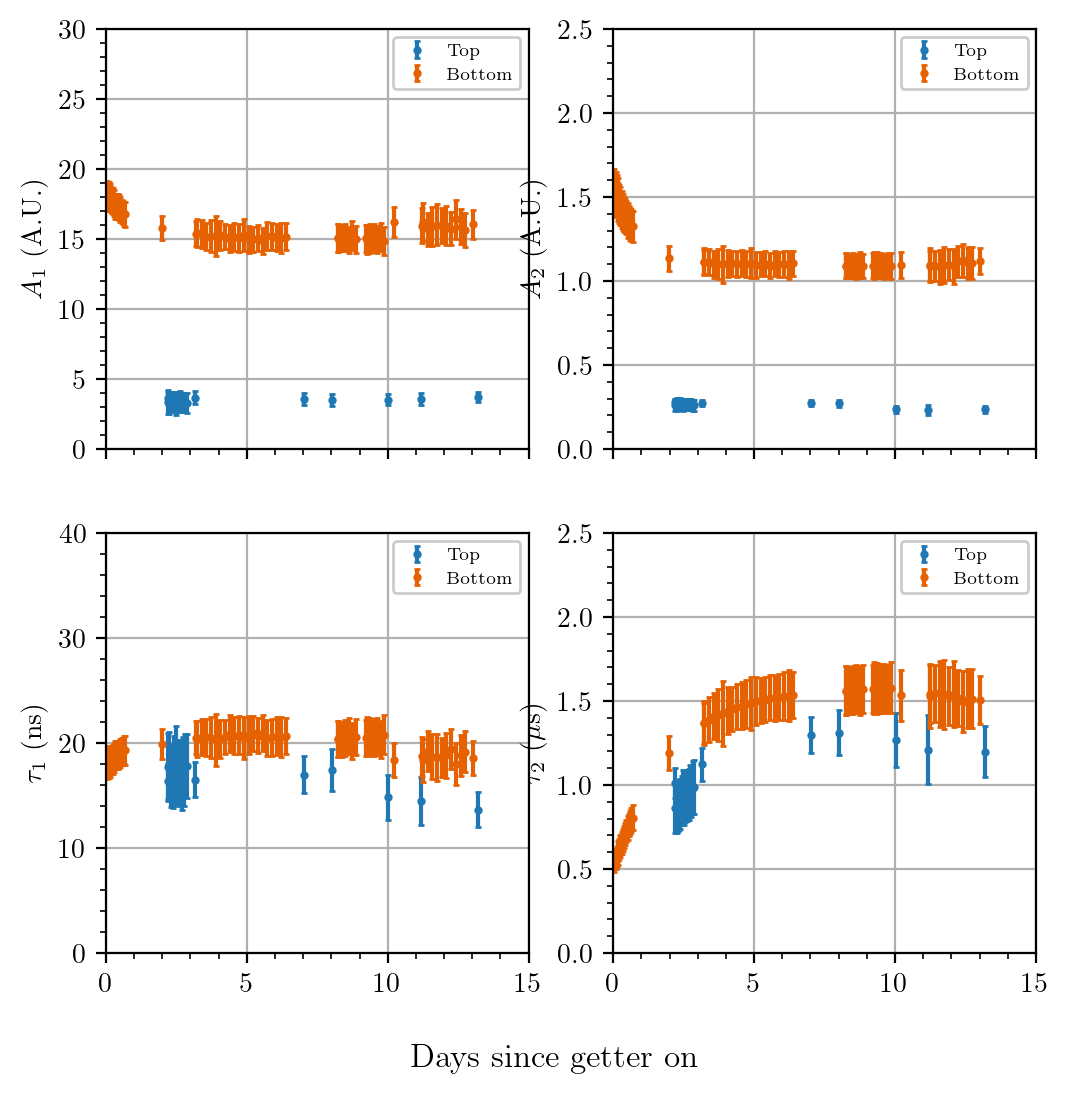

In [28]:
# Make plots for all parameters
# Triplet evolution
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False)
fig.set_size_inches(6, 6)
for i, pos in enumerate(positions):
    axs[0, 0].errorbar(
        triplet_fit[pos]['days'],
        triplet_fit[pos]['a1'],
        yerr=triplet_fit[pos]['a1err'],
        label=f'{pos[0].upper()}{pos[1:]}', color=f'C{i}', linestyle='', linewidth=1.5, fmt='o', markersize=2, capsize=1)
    axs[0, 0].set_ylabel(r'$A_1$ (A.U.)')
    axs[0, 0].set_ylim(0,30)
    axs[0, 1].errorbar(
        triplet_fit[pos]['days'],
        triplet_fit[pos]['a2'],
        yerr=triplet_fit[pos]['a2err'],
        label=f'{pos[0].upper()}{pos[1:]}', color=f'C{i}', linestyle='', linewidth=1.5, fmt='o', markersize=2, capsize=1)
    axs[0, 1].set_ylabel(r'$A_2$ (A.U.)')
    axs[0, 1].set_ylim(0,2.5)
    axs[1, 0].errorbar(
        triplet_fit[pos]['days'],
        triplet_fit[pos]['tau1']*1e3,
        yerr=triplet_fit[pos]['tau1err']*1e3,
        label=f'{pos[0].upper()}{pos[1:]}', color=f'C{i}', linestyle='', linewidth=1.5, fmt='o', markersize=2, capsize=1)
    axs[1, 0].set_ylabel(r'$\tau_1$ (ns)')
    axs[1, 0].set_ylim(0,40)
    axs[1, 1].errorbar(
        triplet_fit[pos]['days'],
        triplet_fit[pos]['tau2'],
        yerr=triplet_fit[pos]['tau2err'],
        label=f'{pos[0].upper()}{pos[1:]}', color=f'C{i}', linestyle='', linewidth=1.5, fmt='o', markersize=2, capsize=1)
    axs[1, 1].set_ylabel(r'$\tau_2$ ($\mu$s)')
    axs[1, 1].set_ylim(0,2.5)

for i in range(2):
    for j in range(2):
        axs[i, j].legend(loc='upper right',fontsize=6)
        axs[i, j].minorticks_on()
        axs[i, j].grid()
fig.supxlabel('Days since getter on')